# Introducing non-linear recharge models to Pastas
*R.A. Collenteur, University of Graz*

This notebook explains the use of non-linear recharge models introduced in Pastas 0.14. To run this notebook and the related non-linear recharge models, it is strongly recommended to install Numba (`pip install numba`, http://numba.pydata.org). This Just-In-Time (JIT) compiler compiles the computationally intensive part of the recharge calculation, making the model virtually as fast as the Linear recharge model.



In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Input data
Input data handling is similar to normal. The only thing that is necessary to check is that the precipitation and evaporation are provided in mm/day. This is required because the parameters for the unsaturated zone module are defined in mm for the length unit and days for the time unit. It is possible to use other units, but this would require manually setting the initial values and parameter boundaries.

In [5]:
head = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

# Make this millimeters per day
rain = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True) * 1e3
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True) * 1e3

## 2. Make a basic model
1. Create a Pastas model
2. Choose and create a unsaturated zone model (you can choose from: `Linear`, `FlexModel`, and `Berendrecht`)
3. Create a `RechargeModel` object and add it to the model
4. Solve and visualize the model

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series rain: freq=D 
INFO: Inferred frequency from time series evap: freq=D 


Model Results head                     Fit Statistics
nfev     43                     EVP             91.09
nobs     644                    R2               0.91
noise    True                   RMSE             0.13
tmin     1985-11-14 00:00:00    AIC             12.84
tmax     2015-06-28 00:00:00    BIC             48.58
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr     initial   vary
rch_A           2.377393   ±27.44%    0.926680   True
rch_n           0.100000   ±17.00%    1.000000   True
rch_a        1722.797039  ±290.15%   10.000000   True
rch_sr        314.689243    ±4.43%  250.000000   True
rch_lp          0.500000     ±nan%    0.500000  False
rch_ks          1.000000    ±4.55%   50.000000   True
rch_gamma       1.198369    ±7.92%    4.000000   True
constant_d     26.536722    ±1.38%   27.900078   Tr

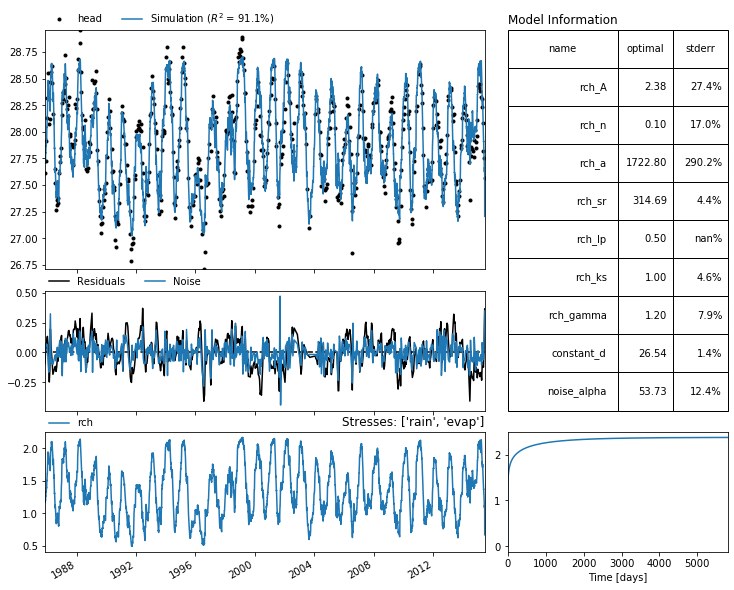

In [25]:
ml = ps.Model(head)

rch = ps.rch.FlexModel()
#rch = ps.rch.Berendrecht()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)
ml.solve()
ml.plots.results()

## 3. Analyze the estimated recharge flux
After the parameter estimation we can take a look at the recharge flux computed by the model. The flux is easy to obtain using the `get_stress` method of the model object, which automatically provides the optimal parameter values that were just estimated. After this, we can look at the recharge flux estimated by the Pastas model. 

Text(0, 0.5, 'Recharge [mm/year]')

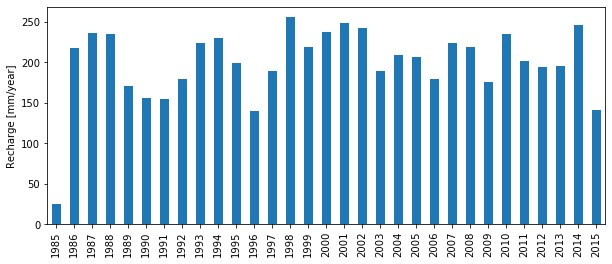

In [33]:
recharge = ml.get_stress("rch").resample("A").sum()
ax = recharge.plot.bar(figsize=(10,4))
ax.set_xticklabels(recharge.index.year)
plt.ylabel("Recharge [mm/year]")